In [61]:
import tensorflow as tf
import numpy as np
import tensorflow
from tensorflow.python.ops.variables import trainable_variables
from tensorflow.keras.layers import MaxPooling2D

#import data
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

x_train = np.array(x_train,np.float32)
x_test = np.array(x_test,np.float32)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [62]:
#dataset param
num_classes = 10
num_features = 784

#training param
learning_rate = 0.001 
training_step  =200
batch_size = 128
display_size = 100
display_step = 10

conv1_filter = 32
conv2_filter = 64

fc1_units = 1024

In [63]:
#normalize data
x_train = x_train.reshape([-1,num_features])
x_test = x_test.reshape([-1,num_features])
x_train = x_train/255.0
x_test = x_test/255.0
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [64]:
#tf.data
data_train = tensorflow.data.Dataset.from_tensor_slices(
 (x_train, y_train)
)
data_train=  data_train.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [65]:
def conv2d(x, w,b,strides =1):
 x = tf.nn.conv2d(x,w,strides=[1,strides,strides,1],padding='SAME')
 x = tf.nn.bias_add(x,b)
 return tf.nn.relu(x)

def maxpool2d(x, k  =2):
 return MaxPooling2D(pool_size=(k,k), strides=(k,k), padding='SAME')(x)



random_normal = tf.initializers.RandomNormal()
weights = {'wc1':tf.Variable(random_normal([5,5,1,conv1_filter])),
          'wc2': tf.Variable(random_normal([5,5,conv1_filter,conv2_filter])),
          'wd1': tf.Variable(random_normal([7 * 7 * 64,fc1_units])),
          'out': tf.Variable(random_normal([fc1_units,num_classes]))}

biases ={'bc1':tf.Variable(tf.zeros([conv1_filter])),
         'bc2':tf.Variable(tf.zeros([conv2_filter])),
         'bd1':tf.Variable(tf.zeros([fc1_units])),
         'out':tf.Variable(tf.zeros([num_classes]))}

def conv_net(x):
 x = tf.reshape(x, [-1,28,28,1])
 conv1 = conv2d(x,weights['wc1'],biases['bc1'])# 28*28*32
 conv1 = maxpool2d(conv1) #14*14*32
 
 conv2 = conv2d(conv1,weights['wc2'],biases['bc2'])# 28*28*64
 conv2 = maxpool2d(conv2) # 7*7*64
 
 fc1 = tf.reshape(conv2,[-1,7*7*64])
 fc1 = tf.add(tf.matmul(fc1,weights['wd1']),biases['bd1'])
 fc1 = tf.nn.relu(fc1)
 
 out = tf.add(tf.matmul(fc1,weights['out']),biases['out'])
 return tf.nn.softmax(out)



In [66]:
#compute loss
def cross_entropy(y_pred,y_true):
 y_true = tf.one_hot(y_true,depth=num_classes)
 y_gred = tf.clip_by_value(y_pred,1e-9,1.0)
 return tf.reduce_mean(-tf.reduce_sum(y_true* tf.math.log(y_pred),1))


#accuracy function
def accuracy(y_pred,y_true):
 correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.cast(y_true,tf.int64))
 return tf.reduce_mean(tf.cast(correct_prediction,tf.float32))


optimizer = tf.optimizers.SGD(learning_rate)


def run_optimization(x,y):
 with tf.GradientTape() as g:
  pred =conv_net(x)
  loss = cross_entropy(pred,y)
  trainable_variables = list(weights.values()) + list(biases.values())
 gradients = g.gradient(loss,trainable_variables)
 optimizer.apply_gradients(zip(gradients,trainable_variables))


 #run training
 
for step, (batch_x,batch_y) in enumerate(data_train.take(training_step),1):
  run_optimization(batch_x,batch_y)
  if step % display_step ==0:
   pred = conv_net(batch_x)
   loss = cross_entropy(pred,batch_y)
   acc = accuracy(pred,batch_y)
   print(f"step{step} loss:{loss} acc:{acc}")

2023-05-11 15:00:31.643778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-05-11 15:00:31.644119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,784]
	 [[{{node Placeholder/_0}}]]


step10 loss:2.314126491546631 acc:0.140625
step20 loss:2.343596935272217 acc:0.1015625
step30 loss:2.27994966506958 acc:0.1875
step40 loss:2.322176933288574 acc:0.1171875
step50 loss:2.298757314682007 acc:0.1328125
step60 loss:2.266681432723999 acc:0.1875
step70 loss:2.2876052856445312 acc:0.171875
step80 loss:2.2990522384643555 acc:0.109375
step90 loss:2.2431249618530273 acc:0.2265625
step100 loss:2.229907512664795 acc:0.2421875
step110 loss:2.231919288635254 acc:0.25
step120 loss:2.2326316833496094 acc:0.28125
step130 loss:2.2245705127716064 acc:0.28125
step140 loss:2.2061283588409424 acc:0.3125
step150 loss:2.1931910514831543 acc:0.359375
step160 loss:2.172940969467163 acc:0.3671875
step170 loss:2.1749215126037598 acc:0.3828125
step180 loss:2.183204174041748 acc:0.3671875
step190 loss:2.1648099422454834 acc:0.359375
step200 loss:2.168658971786499 acc:0.3515625


In [67]:
test_pred = conv_net(x_test)
acc_test = accuracy(test_pred, y_test)
print("Accuracy: ", acc_test)


2023-05-11 15:00:45.178148: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 957.03MiB (rounded to 1003520000)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-11 15:00:45.178217: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-05-11 15:00:45.178229: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 34, Chunks in use: 32. 8.5KiB allocated for chunks. 8.0KiB in use in bin. 1.6KiB client-requested in use in bin.
2023-05-11 15:00:45.178235: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 512B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-05-11 15:00:45.178240: I tensorflow/tsl/framework/bfc_allocator.c

ResourceExhaustedError: {{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[10000,28,28,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

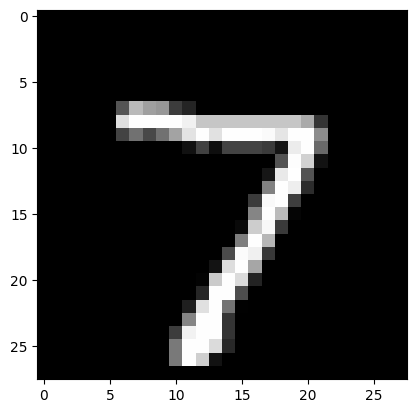

Predict:  [0.11385925 0.1111527  0.08878183 0.08613863 0.09727655 0.09938335
 0.0891812  0.13551699 0.07200667 0.10670278]
Predict:  7


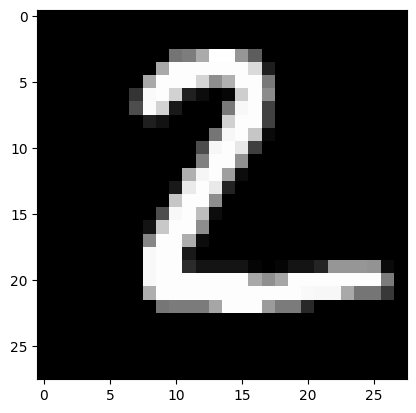

Predict:  [0.10586441 0.10687148 0.12807295 0.11802588 0.08396509 0.0956976
 0.10426534 0.08131274 0.08790935 0.08801512]
Predict:  2


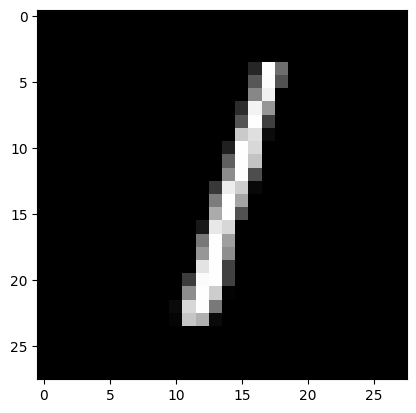

Predict:  [0.08566358 0.11455492 0.10636859 0.10202924 0.09369905 0.09465988
 0.11956727 0.09975824 0.08729038 0.09640888]
Predict:  6


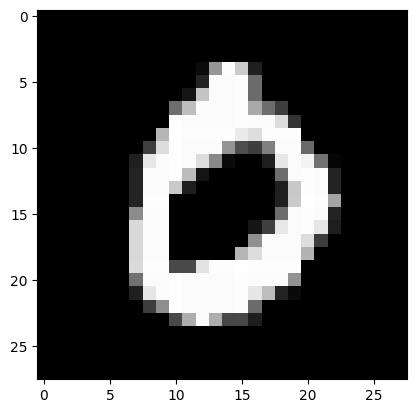

Predict:  [0.15357682 0.09305196 0.11393946 0.11777843 0.10604878 0.07938412
 0.10369486 0.10188027 0.05310445 0.07754087]
Predict:  0


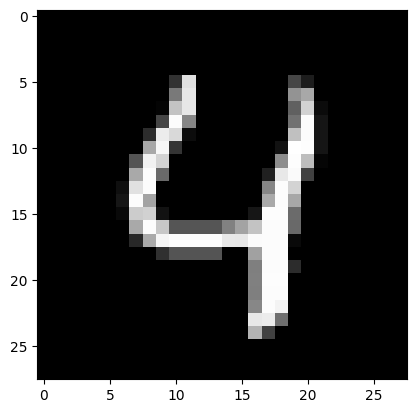

Predict:  [0.11771576 0.08134389 0.09560963 0.09223013 0.11313786 0.11582486
 0.08821052 0.11270048 0.07233471 0.11089221]
Predict:  0


: 

In [68]:
import matplotlib.pyplot as plt
import numpy as np
n_images = 5
test_image = x_test[:n_images]
test_pred = conv_net(test_image)

for i in range(n_images):
 plt.imshow(np.reshape(test_image[i], (28, 28)), cmap='gray')
 plt.show()
 print("Predict: ",test_pred[i].numpy())
 print("Predict: ",np.argmax(test_pred[i].numpy()))